In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

CARD_FACTORY_DATA_DIR = os.path.join(os.environ.get('APPDATA'), 'Godot', 'app_userdata', 'Card Factory', 'data')
GAME_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_Results.csv')
PLAYER_CARD_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_PlayerCardPerformance.csv')
ENEMY_CARD_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_EnemyCardPerformance.csv')

# Game Balance Analysis

Using the GameSimulator component to analyze the balance between auto-generated AI and heuristic-based player win rates.

Also check to see win/lose rates for when the player or enemy puts certain card types into play to check card stat balance.

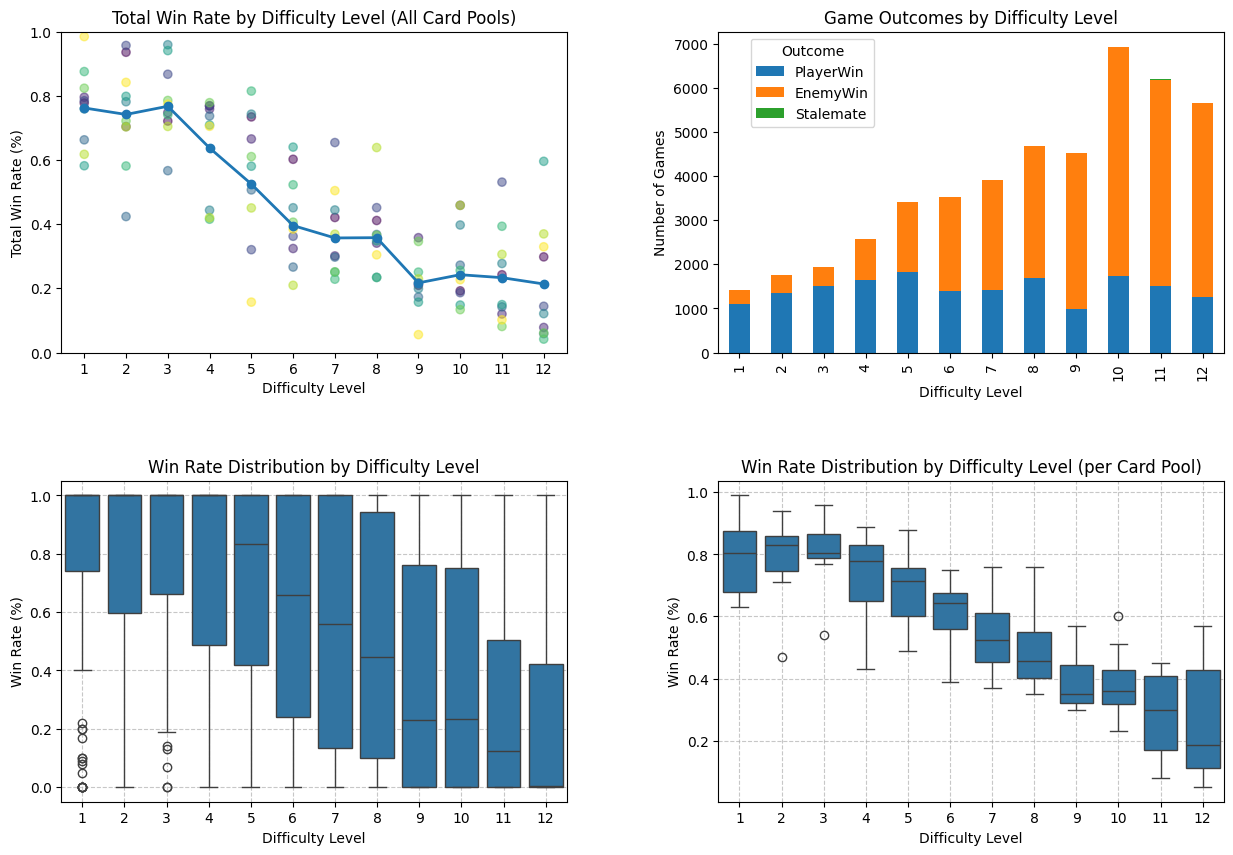

In [28]:
df = pd.read_csv(GAME_RESULTS_PATH, skipinitialspace=True)

cardpool_level_summary = df.groupby(['Pool', 'Level']).agg({
        'TotalGames': 'sum',
        'WinRate': 'mean',
        'PlayerWin': 'sum',
        'EnemyWin': 'sum',
        'Stalemate': 'sum',
        'MaxTurnsReached': 'sum'
    }).round(2).reset_index()

level_summary = df.groupby('Level').agg({
        'TotalGames': 'sum',
        'WinRate': 'mean',
        'PlayerWin': 'sum',
        'EnemyWin': 'sum',
        'Stalemate': 'sum',
        'MaxTurnsReached': 'sum'
    }).round(2)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Total Win Rate by Level
plt.subplot(2, 2, 1)
plt.title('Total Win Rate by Difficulty Level (All Card Pools)')
plt.scatter(cardpool_level_summary['Level'], cardpool_level_summary['PlayerWin'] / cardpool_level_summary['TotalGames'], c=cardpool_level_summary['Pool'], cmap='viridis', alpha=0.5)
plt.plot(level_summary.index, level_summary['PlayerWin'] / level_summary['TotalGames'], marker='o', linewidth=2)
plt.xlabel('Difficulty Level')
plt.xticks(level_summary.index)
plt.ylabel('Total Win Rate (%)')
plt.ylim(0, 1)

# 2. Game Outcomes Stacked Bar Chart
plt.subplot(2, 2, 2)
level_summary[['PlayerWin', 'EnemyWin', 'Stalemate']].plot(
    kind='bar', 
    stacked=True, 
    ax=plt.gca()
)
plt.title('Game Outcomes by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Games')
plt.legend(title='Outcome', bbox_to_anchor=(0.05, 1), loc='upper left')

# 4. Win Rate Distribution for all games
plt.subplot(2, 2, 3)
sns.boxplot(x='Level', y='WinRate', data=df)
plt.title('Win Rate Distribution by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Win Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)

# 4. Win Rate Distribution between Card Pools
plt.subplot(2, 2, 4)
sns.boxplot(x='Level', y='WinRate', data=cardpool_level_summary)
plt.title('Win Rate Distribution by Difficulty Level (per Card Pool)')
plt.xlabel('Difficulty Level')
plt.ylabel('Win Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)